# Create solvated dialanine and test simulation

### Input:
* `data/ala2.pdb`

### Output:
* `ala2_solv.pdb`

Working directory: `ala2_setup`

1. move dialanine to centre of 2.6 x 2.6 x 2.6 nm cell
2. solvate
3. minimize
4. equilibrate $\rightarrow$ produces `data/ala2_solve.pdb`
5. short set of test simulations
6. do some checks

Compare with:
https://markovmodel.github.io/mdshare/ALA2/#alanine-dipeptide

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mdtraj as md 
import openmm as mm
import openmm.unit as unit
from openmm.app import Simulation, ForceField, PDBFile
from openmm.app.modeller import Modeller
import os

from src.filenames import FileNames
from src.util import SimulationParameters, pretty_print
from src.util import save_npz, load_npz, write_pdb
from src.util import create_system, state_data_reporter, hdf5_reporter

pdb = PDBFile('data/ala2.pdb')
p = SimulationParameters(
    simulation_time = 0.1 * unit.nanosecond, 
    report_interval_time = 0.05 * unit.picosecond,
    num_simulations = 5
)
fn = FileNames('data/ala2_setup', p.ns)
pretty_print(p)

simulation_time = 0.1 ns
report_interval_time = 0.05 ps
num_simulations = 5
temperature = 300 K
timestep = 0.002 ps
friction_coeff = 1 /ps
report_interval = 25
total_simulation_time = 0.5 ns
ns = 0.1
total_ns = 0.5


# Move molecule to center of solvation box

In [2]:
traj = md.load_pdb('data/ala2.pdb')

# mdshare dataset = (2.3222 nm)^3
boxdim = (2.6, 2.6, 2.6)

# MDTraj stores positions in nm
xyz_nm = traj.xyz.squeeze() + np.array(boxdim) / 2

# PDB uses Angs
pdb_fn = f'{fn.working_dir}/ala2_center_cell.pdb'
PDBFile.writeFile(pdb.topology, xyz_nm * 10, open(pdb_fn, 'w'))

# Solvate

In [3]:
pdb = PDBFile(pdb_fn)
modeller = Modeller(pdb.topology, pdb.positions)
forcefield = ForceField('amber99sb.xml', 'tip3p.xml')
modeller.addSolvent(forcefield, boxSize=mm.Vec3(*boxdim) * unit.nanometers)

system = create_system(forcefield, modeller.topology)
integrator = mm.LangevinIntegrator(p.temperature, p.friction_coeff, p.timestep)
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)
write_pdb(simulation, f'{fn.working_dir}/ala2_solv.pdb')

num_waters = 0
for r in modeller.topology.residues():
    if r.name == 'HOH':
        num_waters += 1
print(f'{num_waters = }, mdshare dataset = 651 water')

num_waters = 538, mdshare dataset = 651 water


# Minimize

In [4]:
simulation.minimizeEnergy()
write_pdb(simulation, f'{fn.working_dir}/ala2_min.pdb')

# Equilibrate

In [5]:
sdr = state_data_reporter(fn.out(None), p.report_interval)
hdr = hdf5_reporter(fn.h5(None), p.report_interval)
simulation.reporters.append(sdr)
simulation.reporters.append(hdr)

simulation.step(10000)

write_pdb(simulation, f'{fn.working_dir}/ala2_equil.pdb')
os.system(f'cp {fn.working_dir}/ala2_equil.pdb data/ala2_solv.pdb')
for reporter in simulation.reporters:
    if hasattr(reporter, 'close'):
        reporter.close()

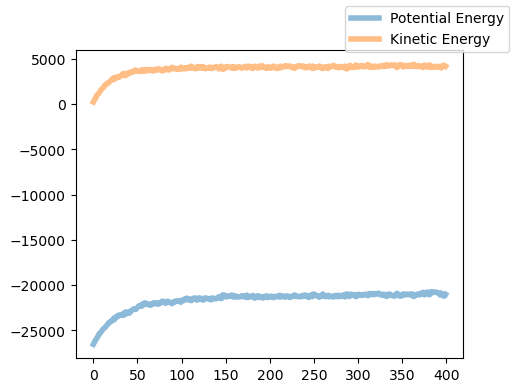

In [6]:
def plot_equil(fig, ax, filename):
    data = np.genfromtxt(filename, delimiter=',')
    ax.plot(data[:, 0], lw=4, alpha=0.5, label='Potential Energy')
    ax.plot(data[:, 1], lw=4, alpha=0.5, label='Kinetic Energy')
    fig.legend(loc='upper right')
    
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_equil(fig, ax, fn.out(None))

In [10]:
import nglview as nv

view = nv.show_structure_file('data/ala2_solv.pdb')
view

NGLWidget()

# Test simulation

In [25]:
pdb = PDBFile('data/ala2_solv.pdb')
forcefield = ForceField('amber99sb.xml', 'tip3p.xml')

sim_start = 0
for sim_num in range(sim_start, p.num_simulations):
    print(f'starting simulation {sim_num + 1} of {p.num_simulations}')
    if sim_num == 0:
        start_positions = pdb.positions
    else:
        start_positions = load_npz(fn.final_positions(sim_num - 1))
    system = create_system(forcefield, pdb.topology)
    integrator = mm.LangevinIntegrator(p.temperature, p.friction_coeff, p.timestep)
    
    simulation = Simulation(pdb.topology, system, integrator)
    simulation.context.setPositions(start_positions)
    sdr = state_data_reporter(fn.out(sim_num), p.report_interval)
    hdr = hdf5_reporter(fn.h5(sim_num), p.report_interval)
    simulation.reporters.append(sdr)
    simulation.reporters.append(hdr)
    simulation.step(round(p.simulation_time / p.timestep))
    
    r = simulation.context.getState(getPositions=True).getPositions()
    save_npz(fn.final_positions(sim_num), r)
    for reporter in simulation.reporters:
        if hasattr(reporter, 'close'):
            reporter.close()

starting simulation 1 of 5
starting simulation 2 of 5
starting simulation 3 of 5
starting simulation 4 of 5
starting simulation 5 of 5


# Checks

1. Look at dihedral histogram
2. Closer look at PBC's
3. Check that featurization is OK


sd.dihedrals.shape = (10000, 2)


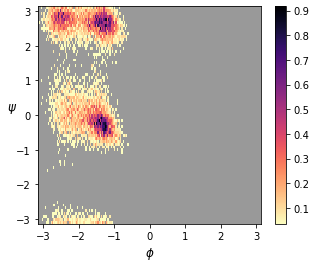

In [28]:
from src.data import OpenMMData
from src.plots import plot_dihedrals_hist2d

sd = OpenMMData(fn.working_dir)
sd.save_feature_data(fn.h5, p.num_simulations)

print(f'{sd.dihedrals.shape = }')
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_dihedrals_hist2d(fig, ax, sd.dihedrals)

## PDB files molecules together, PBC's don't break bonds

In [30]:
traj = md.load_pdb('data/ala2_solv.pdb')
positions = traj.xyz.squeeze()
positions.min(axis=0), positions.max(axis=0)

(array([-0.826 , -0.6829, -0.7597], dtype=float32),
 array([4.0493, 3.9813, 3.5164], dtype=float32))

## Extracted features look continuous

Uses `mdtraj.compute_distances`

num_frames=10000, sd.features.shape=(10000, 45)


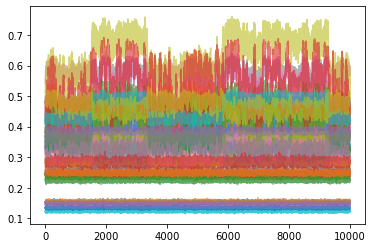

In [51]:
num_frames_sim = int(round(p.simulation_time / p.timestep) / p.report_interval)
num_frames = num_frames_sim * p.num_simulations
print(f'{num_frames=}, {sd.features.shape=}')

plt.plot(sd.features, alpha=0.6);

## Centre of mass does drift across boundaries, right?

/home/bharland/anaconda3/envs/openmm-torch-env/lib/python3.9/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


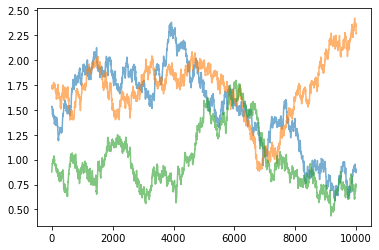

In [50]:
trajs = [md.load(fn.h5(i)) for i in range(p.num_simulations)]
traj = md.join(trajs)
com = md.compute_center_of_mass(traj, select='resname != HOH')
plt.plot(com, alpha=0.6); # [750:1000]);